## PUSH 2 PACS

# Imports

In [1]:
import JupyterNotebooksLib as slicernb


# Load DICOM data

In [2]:
# sample head and neck data from publicly available dataset:
# https://wiki.cancerimagingarchive.net/display/Public/Head-Neck-PET-CT

from DICOMLib import DICOMUtils
dicomDataDir = 'data/HN-CHUM-061/'
loadedNodeIDs = []

with DICOMUtils.TemporaryDICOMDatabase() as db:
  DICOMUtils.importDicom(dicomDataDir, db)
  patientUIDs = db.patients()
  for patientUID in patientUIDs:
    loadedNodeIDs.extend(DICOMUtils.loadPatientByUID(patientUID))
    
print(loadedNodeIDs)

Switching to temporary DICOM database: C:/Users/rrsavjani/AppData/Local/Temp/Slicer/20201016_181901_TempDICOMDatabase
Loading with imageIOName: GDCM
Window/level found in DICOM tags (center=40.0, width=400.0) has been applied to volume 3: Standard-Full
Loading with imageIOName: GDCM


Cannot get DICOM slice positions for volume 4974022: RTdose_CTsim->CT(PET-CT)


['vtkMRMLScalarVolumeNode1', 'vtkMRMLScalarVolumeNode2', 'vtkMRMLScalarVolumeNode3']


In [3]:
ct=slicer.util.getNode(loadedNodeIDs[0])
rtdose=slicer.util.getNode(loadedNodeIDs[2])
ct.GetImageData().GetDimensions()
rtdose.GetImageData().GetDimensions()

(200, 200, 130)

# Visualize slices

In [14]:
# Select CT as background and rtdose as foreground
slicer.util.setSliceViewerLayers(background=ct, foreground=rtdose)
slicer.util.setSliceViewerLayers(foregroundOpacity=0.3)

# set threshold of rtdose map between 5 and 75 Gy
rtdoseDisplay = rtdose.GetDisplayNode()
rtdoseDisplay.SetThreshold(5, 75)


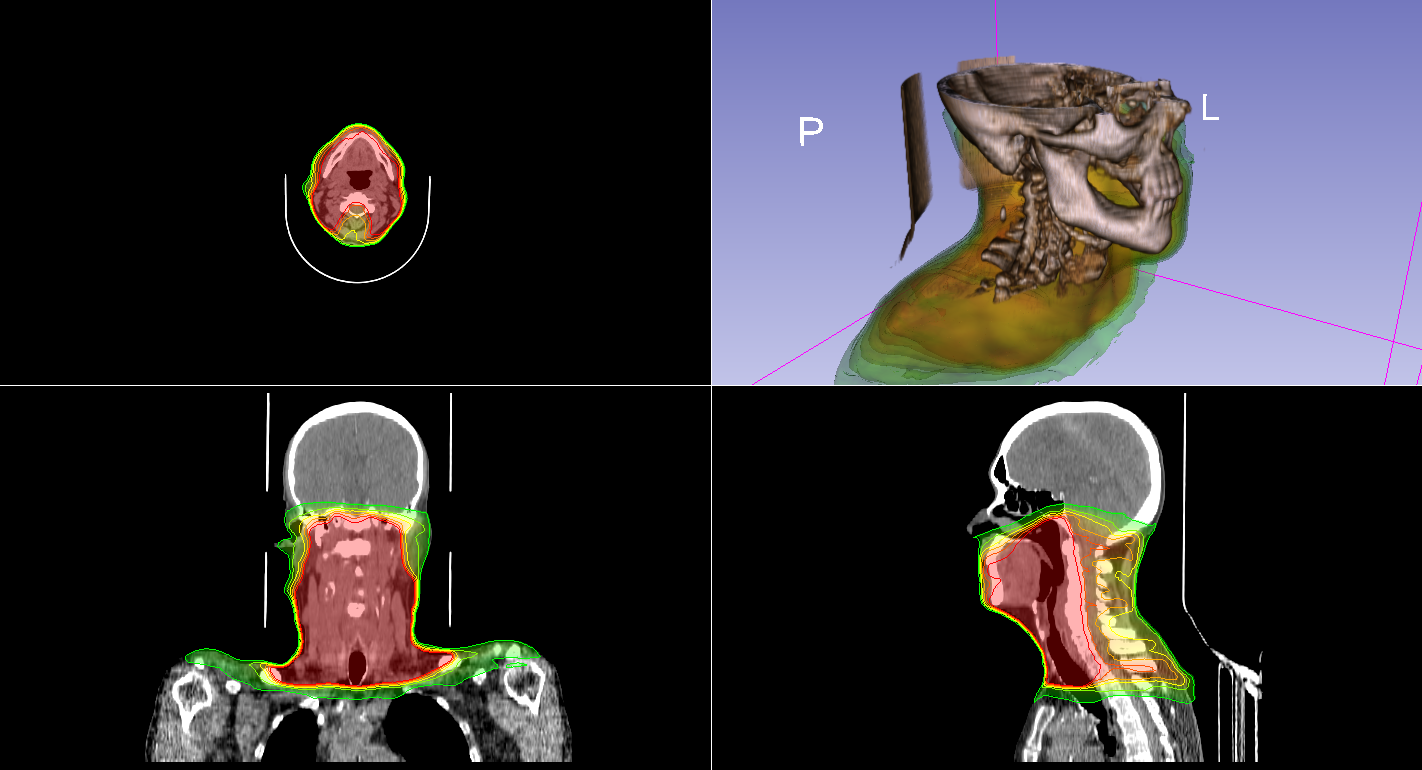

In [15]:
# Enable 3D volume rendering
slicernb.showVolumeRendering(ct)

# Show slice and 3D views
slicernb.ViewDisplay("FourUp")  # You can also try: FourUp, OneUpRedSlice, OneUp3D

In [ ]:
# Lightbox view
#slicernb.ViewLightboxDisplay("Red", columns=3, rows=3, rangeShrink=[45,50])

In [17]:
# Interactive Slice view display
from ipywidgets import interact
@interact(position=(0,100))
def update(position=50):
    return slicernb.ViewSliceDisplay('Red', positionPercent=position)

interactive(children=(IntSlider(value=50, description='position'), Output()), _dom_classes=('widget-interact',…

In [19]:
# Enable volume cropping
displayNode = slicer.modules.volumerendering.logic().GetFirstVolumeRenderingDisplayNode(ct)
displayNode.SetCroppingEnabled(True)
roiNode = displayNode.GetROINode()

# 3D view display
slicernb.reset3DView()
from ipywidgets import interact
@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-180.0,180.0,5), cropx=(0,70,5), cropy=(0,120,5), cropz=(0, 80, 5))
def update(roll=0, pitch=0, yaw=0, cropx=70, cropy=120, cropz=80):
    roiNode.SetRadiusXYZ([cropx, cropy, cropz])
    return slicernb.View3DDisplay(0, orientation=[roll, pitch, yaw])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

# Create isodose lines

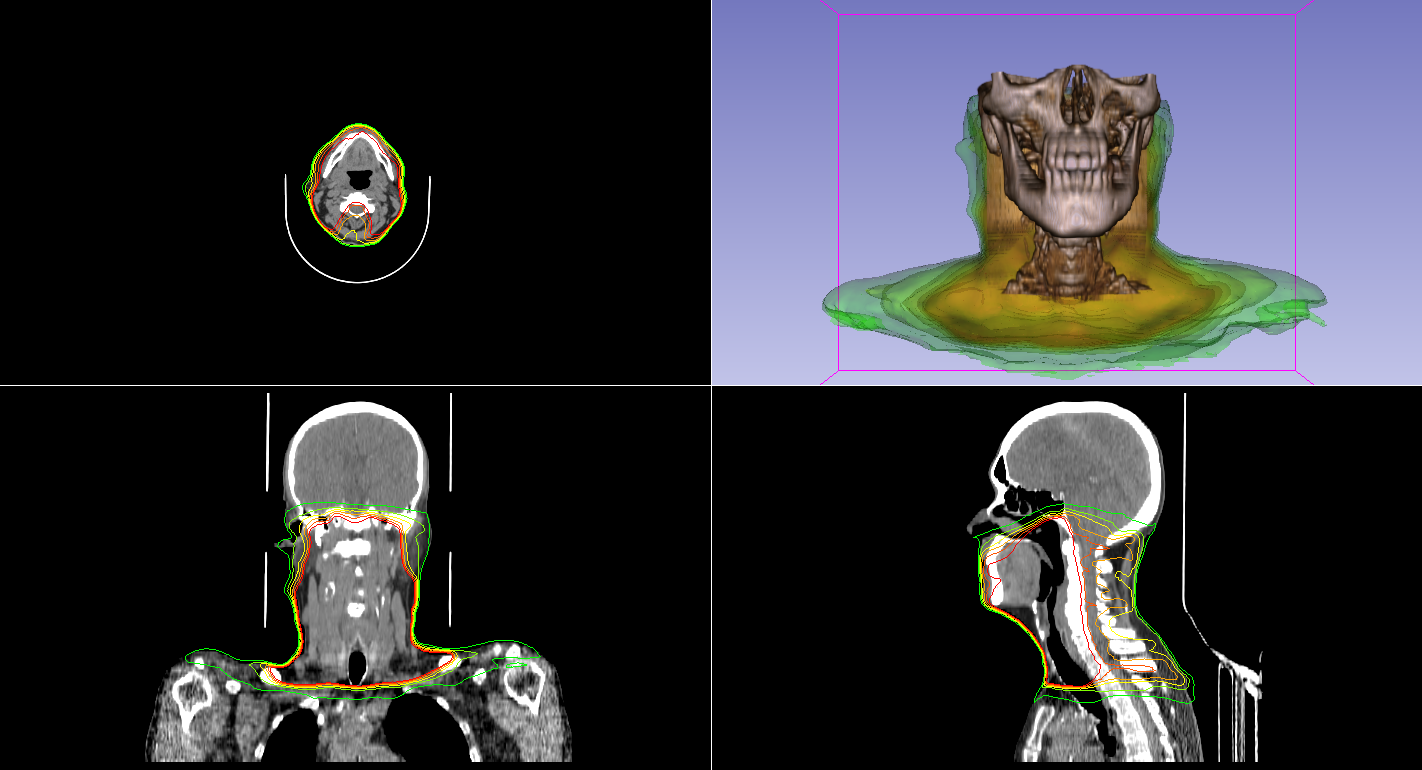

In [9]:
# change to isodose module
slicer.util.selectModule('Isodose')

# create custom color table
hncolors = slicer.vtkMRMLColorTableNode()
hncolors.SetTypeToUser()
hncolors.SetNumberOfColors(5)
hncolors.SetName("hncolors")

hncolors.SetColor(0, 0,0,255,1.0)   # blue
hncolors.SetColor(1, 0,255,255,1.0) # cyan
hncolors.SetColor(2, 0,255,0,1.0)   # green
hncolors.SetColor(3, 255,255,0,1.0) # yellow
hncolors.SetColor(4, 255,165,0,1.0) # orange
hncolors.SetColor(5, 255,0,0,1.0)   # red

#vtkMRMLIsodoseNode 
doseNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLIsodoseNode')
doseNode.SetAndObserveColorTableNode(hncolors)
doseNode.SetAndObserveDoseVolumeNode(rtdose)

# logic for setting isodose lines
doseLogic = slicer.modules.isodose.logic()
doseLogic.SetupColorTableNodeForDoseVolumeNode(rtdose)

# draw isodose lines
doseLogic.SetNumberOfIsodoseLevels(doseNode, 6)
doseLogic.CreateIsodoseSurfaces(doseNode)

# adjust isodose view settings
doseNode.SetShowIsodoseLines(True)
doseNode.SetShowScalarBar2D(True)
#doseNode.SetShowIsodoseSurfaces(False)

# Show slice and 3D views
slicer.util.setSliceViewerLayers(foregroundOpacity=0)
slicernb.ViewDisplay("FourUp") 

# Export CT and RTDose to standard DICOM volumes

In [24]:
outputFolder = "dicom-output/"

# Create patient and study and put the volume under the study
shNode = slicer.vtkMRMLSubjectHierarchyNode.GetSubjectHierarchyNode(slicer.mrmlScene)
ctShItemID = shNode.GetItemByDataNode(ct)

import DICOMScalarVolumePlugin
exporter = DICOMScalarVolumePlugin.DICOMScalarVolumePluginClass()

# export ct to dicom
exportables = exporter.examineForExport(ctShItemID)
for exp in exportables:
  exp.directory = outputFolder
exporter.export(exportables)

# resample rtdose to be in same space as ct
parameters = {'inputVolume':rtdose, 'referenceVolume':ct, 'outputVolume':rtdose, 
                          'interpolationMode':'Linear'}
cliNode = slicer.cli.run(slicer.modules.brainsresample, None, parameters)

# export rtdose to dicom
rtdoseShItemID = shNode.GetItemByDataNode(rtdose)
exportables = exporter.examineForExport(rtdoseShItemID)
for exp in exportables:
  exp.directory = outputFolder
exporter.export(exportables)

Export scalar volume '3: Standard-Full' to directory C:/Users/rrsavjani/Box/QualityPresentation/RadiologyImagingCancer/push2pacs/dicom-output/ScalarVolume_7
Export scalar volume '4974022: RTDOSE: RTdose_CTsim->CT(PET-CT) [1]' to directory C:/Users/rrsavjani/Box/QualityPresentation/RadiologyImagingCancer/push2pacs/dicom-output/ScalarVolume_11


''

In [21]:
# export rtdose to dicom
shNode = slicer.vtkMRMLSubjectHierarchyNode.GetSubjectHierarchyNode(slicer.mrmlScene)
rtdoseShItemID = shNode.GetItemByDataNode(rtdose)
exportables = exporter.examineForExport(rtdoseShItemID)
for exp in exportables:
  exp.directory = outputFolder
exporter.export(exportables)

Export scalar volume '4974022: RTDOSE: RTdose_CTsim->CT(PET-CT) [1]' to directory C:/Users/rrsavjani/Box/QualityPresentation/RadiologyImagingCancer/push2pacs/dicom-output/ScalarVolume_11


''

# Get range of  dose map

In [12]:
# note the dose range 
doseRange = rtdose.GetImageData().GetScalarRange()
print(doseRange)

(0.0, 57.87622833251953)
